In [2]:
import sys
sys.path.append('..')

import HTorch
import torch
import numpy as np
import math
from data_utils.data_handler import DataHandler
from data_utils.relations import Relations
import matplotlib.pyplot as plt
import time
from ConeModel import *

In [3]:
cpu = torch.device("cpu"); gpu = torch.device(type='cuda', index=0)
device = cpu
torch.set_default_tensor_type('torch.DoubleTensor')

### Load data

**Ground truth transitive closure** 

In [4]:
import pandas as pd
from IPython.display import clear_output
import random
import networkx as nx


In [6]:
### load basic edges
file_path = '../data_utils/data/maxn/mammal_closure.tsv.train_0percent'
df_indexed = pd.read_csv(file_path, delimiter='\t', encoding='utf-8',header=None)
### load vocab
filename = '../data_utils/data/maxn/mammal_closure.tsv.vocab'
element_index = {}

with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
        index, element = line.strip().split('\t')
        element_index[int(index)] = element

In [7]:
G_load = nx.DiGraph()
G_load.add_edges_from(df_indexed.to_numpy())

In [8]:
G_closure = nx.transitive_closure(G_load)
G_closure = G_closure.edges()
true_closure = np.array(G_closure)

**Implied basic relations** 

In [9]:
source ='infinity'
radius = 0.05 # best radius from validation = raidus from training
# radius = 0.1 # hand tuned for visualization
# for mammal only
size = 1179 

In [10]:
### Load model
# load_name = 'trained_models/epoch_1000_dim2_10percent' # model
load_name = 'trained_models/mammal_with_vocab' # model_weight
hyp_cone = UmbralCone(source = source, radius = radius, size = size, dim = 2, curvature = -1)
hyp_cone.to(device)
hyp_cone.load_state_dict(torch.load(load_name+".pth")["model_weight"])
vocab = torch.load(load_name+".pth")["vocab"]

In [11]:
inputs = np.arange(size)
paired = sorted(zip(vocab,inputs))
vocab_sorted,inputs_sorted = zip(*paired)
new_element_index = dict(zip(inputs_sorted, [element_index[int(word)] for word in vocab_sorted]))

In [12]:
vocab = torch.load(load_name+".pth")["vocab"]
vocab = [int(i) for i in vocab]

In [13]:
### dictionary: from vocab index to embedding index
vocab_idx = np.arange(size)
emb_idx = [vocab.index(x) for x in vocab_idx]
emb_from_vocab = dict(zip(vocab_idx, emb_idx))


In [14]:
inputs = torch.tensor(np.arange(size))
embedding = hyp_cone.emb(inputs).detach().numpy()
basic_relations = df_indexed.to_numpy()

### convert these relations to embedding idx
f = np.vectorize(emb_from_vocab.get)
basic_relations = f(basic_relations)

basic_relation_emb = hyp_cone.emb(torch.tensor(basic_relations)).detach().numpy()

In [15]:
########################
### Pick labels by hand
########################

# [emb_from_vocab[x] for x in longest_path[:]]
longest_path = nx.dag_longest_path(G_load)
sample_idx = [13, 4,8,154, 129]+[23, 114, 102, 985, 893, 442, 150, 93, 130, 106, 1175, 539, 106, 587, 43]
labels = [new_element_index[x][:-5] for x in sample_idx]
label_coordinates = hyp_cone.emb(torch.tensor(sample_idx)).detach().numpy()

### Visualization 


**With true edges**

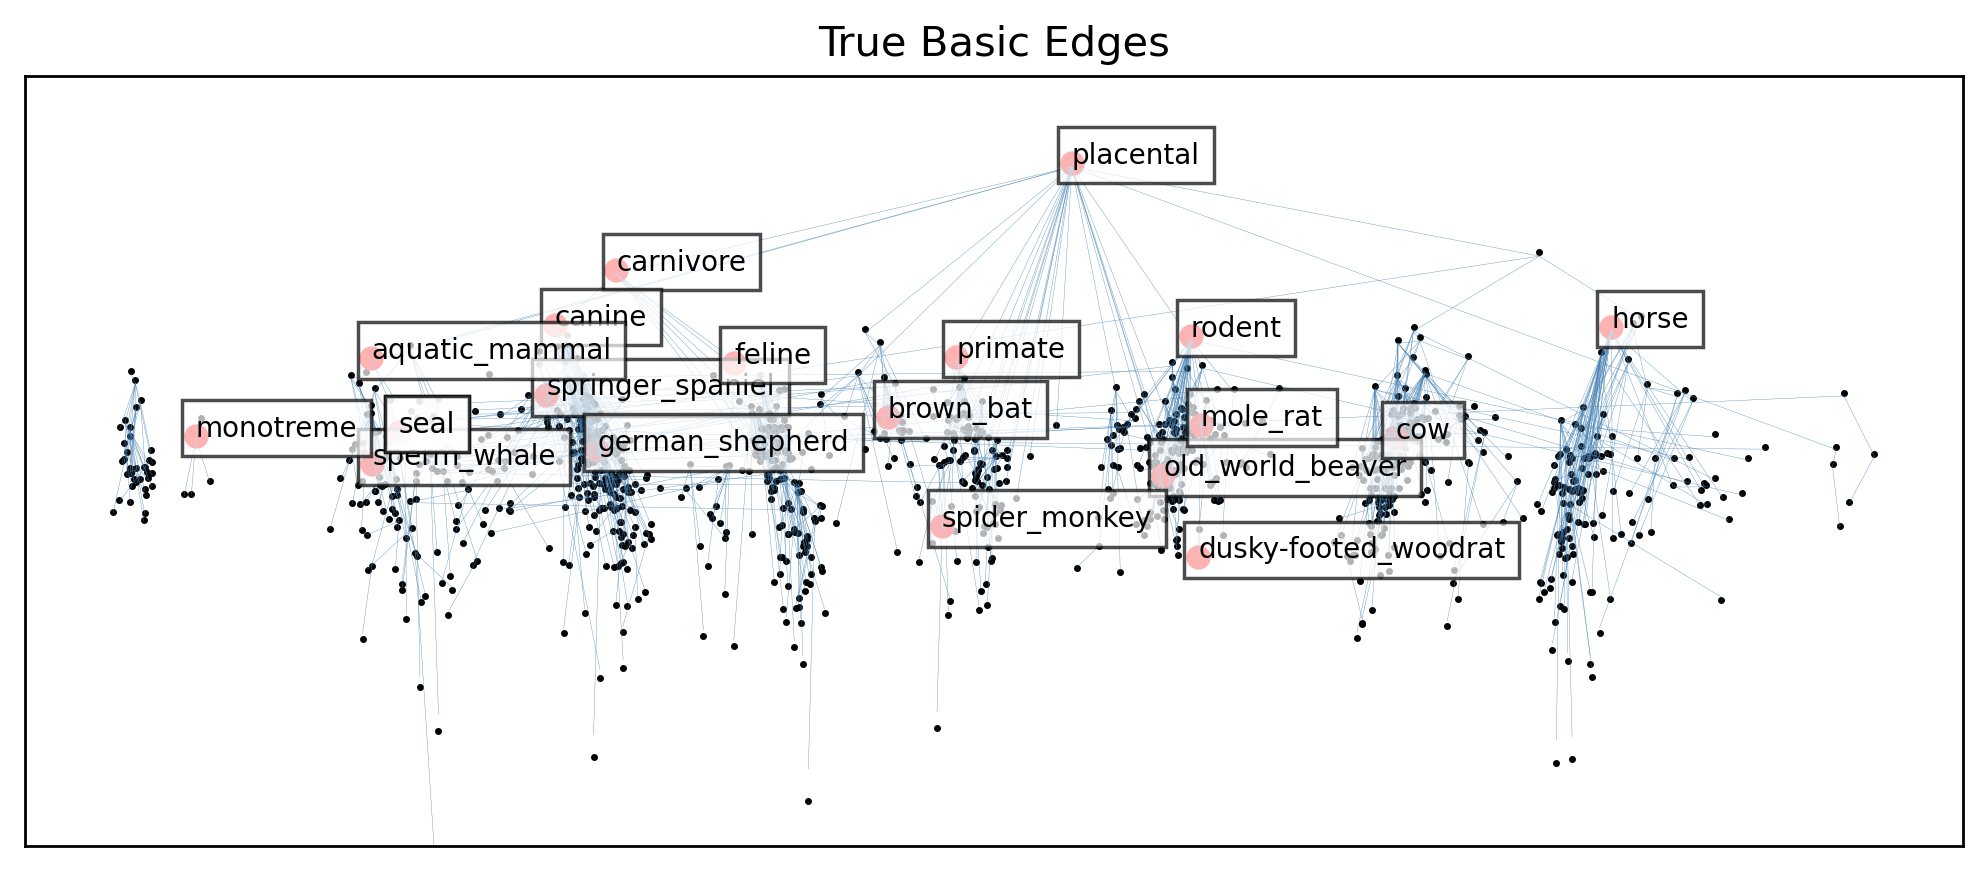

In [17]:
Label = True

offset = -min(np.log(embedding.T[1])) 

plt.figure(dpi=250, figsize = (10,4))

plt.yscale('log') 
plt.minorticks_off()
plt.ylim(1.5e-3,1)    


for pair in basic_relation_emb:
    plt.plot(pair[:, 0], np.log(pair[:, 1]+offset), color="steelblue", linewidth=0.1)
plt.scatter(embedding.T[0],np.log(embedding.T[1])+offset, s = 1, c = "black")

if Label:
    for label, coord in zip(labels, label_coordinates):
        x = coord[0]
        y = np.log(coord[1])+offset
        plt.scatter(x, y, c = "r")
        plt.text(x, y, label, fontsize=8, bbox=dict(facecolor='white', edgecolor='black', alpha = 0.7))

plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)    
plt.title("True Basic Edges")    
plt.show()

**With implied edges**